# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [46]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


The structure of azdias and customers df looks similar having more then 360 columns, just the customer df has 3 more columns.

In [5]:
customers_len = len(customers)
general_pop_len = len(azdias)
print(f'Len of customers = {customers_len}')
print(f'Len of general pop = {general_pop_len}')
print(f'Potencial clients = {general_pop_len - customers_len}')

Len of customers = 191652
Len of general pop = 891221
Potencial clients = 699569


As we can see there 699569 possible new clients for mail-order sales company 

In [10]:
np.setdiff1d(customers.columns, azdias.columns)

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file.

In [11]:
customers.dtypes[customers.dtypes == 'object']

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
PRODUCT_GROUP               object
CUSTOMER_GROUP              object
dtype: object

In [12]:
azdias.dtypes[customers.dtypes == 'object']

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

In [13]:
for col in customers.dtypes[customers.dtypes == 'object'].index:
    print(f'{col} = {customers[col].unique}')

CAMEO_DEU_2015 = <bound method Series.unique of 0          1A
1         NaN
2          5D
3          4C
4          7B
         ... 
191647     1C
191648     5B
191649     4D
191650     4C
191651     5C
Name: CAMEO_DEU_2015, Length: 191652, dtype: object>
CAMEO_DEUG_2015 = <bound method Series.unique of 0           1
1         NaN
2           5
3           4
4           7
         ... 
191647      1
191648      5
191649      4
191650      4
191651      5
Name: CAMEO_DEUG_2015, Length: 191652, dtype: object>
CAMEO_INTL_2015 = <bound method Series.unique of 0          13
1         NaN
2          34
3          24
4          41
         ... 
191647     14
191648     32
191649     24
191650     24
191651     33
Name: CAMEO_INTL_2015, Length: 191652, dtype: object>
D19_LETZTER_KAUF_BRANCHE = <bound method Series.unique of 0                  D19_UNBEKANNT
1               D19_BANKEN_GROSS
2                  D19_UNBEKANNT
3         D19_NAHRUNGSERGAENZUNG
4                     D19_SCHUHE
        

The columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 should be numerics columns

In [14]:
customers['CAMEO_DEUG_2015'] = pd.to_numeric(customers['CAMEO_DEUG_2015'].replace('X', -1))

In [15]:
customers['CAMEO_INTL_2015'] = pd.to_numeric(customers['CAMEO_INTL_2015'].replace('XX', -1))

In [16]:
for col in azdias.dtypes[customers.dtypes == 'object'].index:
    print(f'{col} = {azdias[col].unique}')

CAMEO_DEU_2015 = <bound method Series.unique of 0         NaN
1          8A
2          4C
3          2A
4          6B
         ... 
891216     7A
891217     9D
891218     4C
891219     9D
891220     6B
Name: CAMEO_DEU_2015, Length: 891221, dtype: object>
D19_LETZTER_KAUF_BRANCHE = <bound method Series.unique of 0                        NaN
1                        NaN
2              D19_UNBEKANNT
3              D19_UNBEKANNT
4                 D19_SCHUHE
                 ...        
891216         D19_HAUS_DEKO
891217         D19_UNBEKANNT
891218    D19_BEKLEIDUNG_GEH
891219         D19_UNBEKANNT
891220                   NaN
Name: D19_LETZTER_KAUF_BRANCHE, Length: 891221, dtype: object>
EINGEFUEGT_AM = <bound method Series.unique of 0                         NaN
1         1992-02-10 00:00:00
2         1992-02-12 00:00:00
3         1997-04-21 00:00:00
4         1992-02-12 00:00:00
                 ...         
891216    1992-02-10 00:00:00
891217    1992-02-10 00:00:00
891218    1992-02-

All azdias object columns are indeed objects

In [24]:
def get_statistics_about_nan(df):
    """Get the statistic informations about the 
    nan values of a dataframe

    Parameters
    ----------
    df: Pandas df
        General population or custormer dataframe
    """
    percentage_of_na = df.isna().sum() / df.shape[0]
    percentage_of_na = percentage_of_na.sort_values(ascending=False)
    print(percentage_of_na.describe())
    plt.hist(percentage_of_na)
    plt.title('% of nan in each col', weight='bold')
    plt.show();

count    369.000000
mean       0.196049
std        0.151437
min        0.000000
25%        0.000000
50%        0.267574
75%        0.267574
max        0.998769
dtype: float64


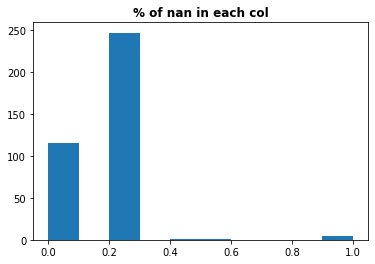

In [25]:
get_statistics_about_nan(customers)

75% of the columns of customers df have less then 27% of na values

In [26]:
percentage_of_na[percentage_of_na > 0.4].index

Index(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1',
       'KK_KUNDENTYP', 'EXTSEL992'],
      dtype='object')

From the above columns, I only could find the meaning of KK_KUNDENTYP, so all other I gonna drop and fill with -1 the nan cells of KK_KUNDENTYP

In [27]:
customers['KK_KUNDENTYP'] = customers['KK_KUNDENTYP'].fillna(-1)

In [28]:
customers_filtered = customers.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992'], axis=1)

count    366.000000
mean       0.102680
std        0.121640
min        0.000000
25%        0.000000
50%        0.118714
75%        0.120230
max        0.998648
dtype: float64


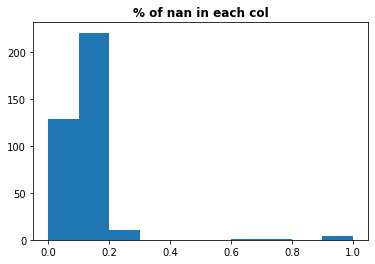

In [29]:
get_statistics_about_nan(azdias)

The azdias have even less na values, 75% of its columns have less then 12% of nan values

In [31]:
azdias['KK_KUNDENTYP'] = azdias['KK_KUNDENTYP'].fillna(-1)

In [32]:
azdias_filtered = azdias.drop(['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992'], axis=1)

Changing nan values for -1

In [33]:
def replace_nan(df, int_to_replace=-1):
    """Replace nan values from the dataframe

    Parameters
    ----------
    df: Pandas df
        General population or custormer dataframe
    int_to_replace: int
        The value that will replace the nan values
    """
    df[df.dtypes[df.dtypes == 'object'].index] = \
        df[df.dtypes[df.dtypes == 'object'].index].apply(lambda x: x.fillna(value=str(int_to_replace)))
    df[df.dtypes[df.dtypes != 'object'].index] = \
        df[df.dtypes[df.dtypes != 'object'].index].apply(lambda x: x.fillna(value=int_to_replace))

In [34]:
replace_nan(customers_filtered)

In [35]:
replace_nan(azdias_filtered)

## Are the distribution between ages the same between general population and customers?

In [87]:
def plot_comparative_bar_plot(col,
                              azdias_df,
                              customers_df,
                              y_label,
                              title,
                              legend1='General',
                              legend2='Customers',
                              width = 0.35,
                              figsize=(12,6),
                              color1='royalblue',
                              color2='seagreen'):
    """Plot a comparative bar plot

    Parameters
    ----------
    col: string
        The column name that is used to draw the bar
    azdias_df: Pandas df
        General population dataframe
    customers_df: Pandas df
        Customers dataframe
    y_label: string
        The y label text
    title: string
        The plot title
    legend1: string
        The legend of the azdias_df
    legend2: string
        The legend of the customers_df
    width: float
        The bar width
    figsize: tuple
        The plot width and height
    """
    azdias_count = azdias_df[col].value_counts()
    customers_count = customers_df[col].value_counts()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xticks(azdias_count.index)
    rects1 = ax.bar(azdias_count.index, azdias_count.values/len(azdias_df), width, color=color1)
    rects2 = ax.bar(customers_count.index+width, customers_count.values/len(customers_df), width, color=color2)

    ax.set_ylabel(y_label)
    ax.set_title(title)

    ax.legend( (rects1[0], rects2[0]), (legend1, legend2) )

    plt.show()

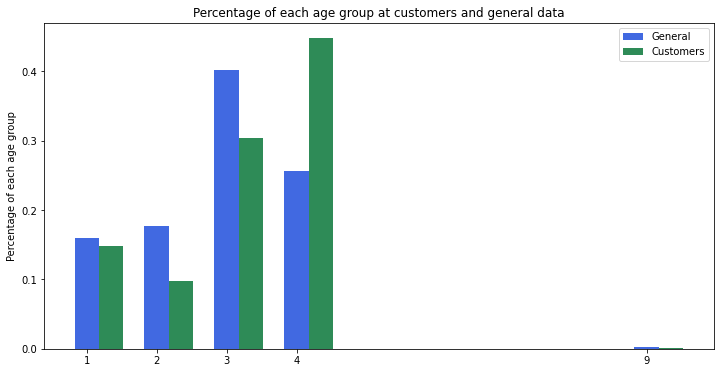

In [37]:
plot_comparative_bar_plot('ALTERSKATEGORIE_GROB', azdias_filtered, customers_filtered, 'Percentage of each age group', 'Percentage of each age group at customers and general data')

1	< 30 years
2	30 - 45 years
3	46 - 60 years
4	> 60 years
9	uniformly distributed

As we can see, more than 40% of customers are over 60 years old, while this share in the general population is 25%.

## Are the distribution between gender the same between general population and customers?

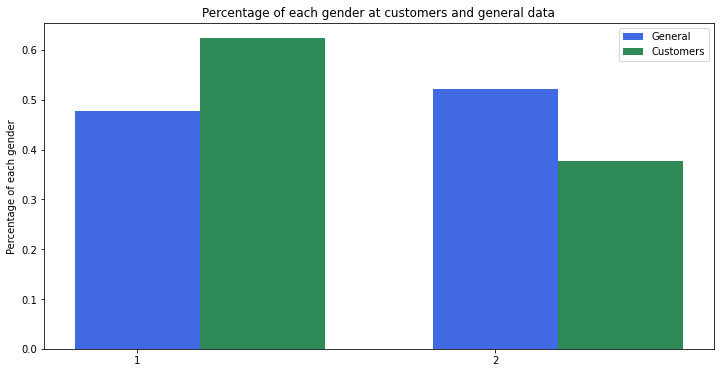

In [38]:
plot_comparative_bar_plot('ANREDE_KZ', azdias_filtered, customers_filtered, 'Percentage of each gender', 'Percentage of each gender at customers and general data')

There are more men at the custormers database but at the general population database there are more women.

## Are the distribution between income the same between general population and customers?

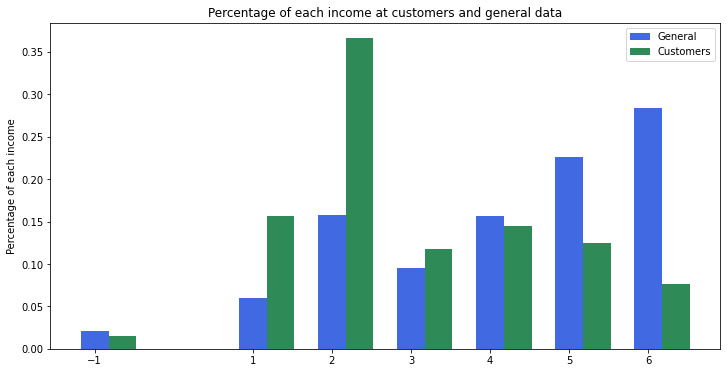

In [39]:
plot_comparative_bar_plot('HH_EINKOMMEN_SCORE', azdias_filtered, customers_filtered, 'Percentage of each income', 'Percentage of each income at customers and general data')

-1, 0	unknown
1	highest income
2	very high income
3	high income
4	average income
5	lower income
6	very low income

An interesting fact is that there are more clients with higher income.

# Formating the data to use unsupervised learning techniques

In [40]:
customers_without_cols = customers_filtered.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

Dropping the customer specifics columns

In [41]:
obj_cols = customers_without_cols.dtypes[customers_without_cols.dtypes == 'object'].index

Getting the columns whose type is object

In [42]:
le = LabelEncoder()

In [43]:
customers_without_cols[obj_cols] = customers_without_cols[obj_cols].apply(le.fit_transform)

In [44]:
azdias_filtered[obj_cols] = azdias_filtered[obj_cols].apply(le.fit_transform)

Applying the LabelEncoder to the customers df and to the general DF

In [45]:
print(f"customers_without_cols.shape = {customers_without_cols.shape}")
print(f"azdias_filtered.shape = {azdias_filtered.shape}")

customers_without_cols.shape = (191652, 361)
azdias_filtered.shape = (891221, 361)


In [62]:
from sklearn.preprocessing import MinMaxScaler
customers_filtered_scalled = MinMaxScaler().fit_transform(customers_without_cols)

Scalling the customers data

In [48]:
# Tiveram alguns erros de tipo
for col in azdias_filtered.columns:
    try:
        np.unique(azdias_filtered[col])
    except:
        print(col)

CAMEO_DEUG_2015
CAMEO_INTL_2015


The general df had some columns with inconsistent data, as we can see those colums were CAMEO_DEUG_2015 and
CAMEO_INTL_2015

In [53]:
azdias_filtered['CAMEO_DEUG_2015'] = pd.to_numeric(azdias_filtered['CAMEO_DEUG_2015'].replace('X', '-1'))

In [54]:
azdias_filtered['CAMEO_INTL_2015'] = pd.to_numeric(azdias_filtered['CAMEO_INTL_2015'].replace('XX', '-1'))

In [63]:
azdias_filtered_scalled = MinMaxScaler().fit_transform(azdias_filtered)

Scalling the general data

In [56]:
print(f"len(customers_filtered_scalled) = {len(customers_filtered_scalled)}")
print(f"len(azdias_filtered_scalled) = {len(azdias_filtered_scalled)}")

len(customers_filtered_scalled) = 191652
len(azdias_filtered_scalled) = 891221


In [64]:
combined_arr = np.concatenate((customers_filtered_scalled, azdias_filtered_scalled), axis=0)

Combining the data, so we can use the same unsupervised learning model to compare them

In [61]:
combined_arr.shape

(1082873, 361)

Applying PCA mantaining the explained variance at 90%

In [65]:
pca = PCA(n_components = 0.9)
pca.fit(combined_arr)
combined_arr_reduced = pca.transform(combined_arr)

In [66]:
combined_arr_reduced.shape

(1082873, 103)

As we can see the PCA maintained 103 columns

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [69]:
def calculate_WSS(points, kmax):
  """Calculate the cluster WSS for each k in the range from 1
  to kmax

    Parameters
    ----------
    points: nd.array
        Numpy array of points
    kmax: integer
        The max number of clusters
    Returns
    ----------
    List
      List of the wss for each k
    """
  sse = []
  for k in range(1, kmax+1):
    print(f'k = {k}')
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
    print(f'curr_sse = {curr_sse}')
    sse.append(curr_sse)
  return sse

In [70]:
sse = calculate_WSS(combined_arr_reduced, 10)

k = 1
curr_sse = 12804034.227925349
k = 2
curr_sse = 2390038.403517254
k = 3
curr_sse = 954350.8376300808
k = 4
curr_sse = 990138.771122019
k = 5
curr_sse = 854390.0523483595
k = 6
curr_sse = 904274.2103336053
k = 7
curr_sse = 701661.198649535
k = 8
curr_sse = 652266.908288324
k = 9
curr_sse = 670039.7194091927
k = 10
curr_sse = 625886.5904376616


The number of clusters that minimize the WSS is 10

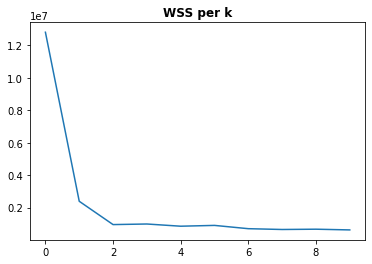

In [71]:
plt.plot(sse)
plt.title('WSS per k', weight='bold')
plt.show();

In [72]:
kmeans = KMeans(n_clusters = 10).fit(combined_arr_reduced)

In [77]:
customers_labels = kmeans.labels_[:191652]
azdias_filtered_labels = kmeans.labels_[191652:]


In [78]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

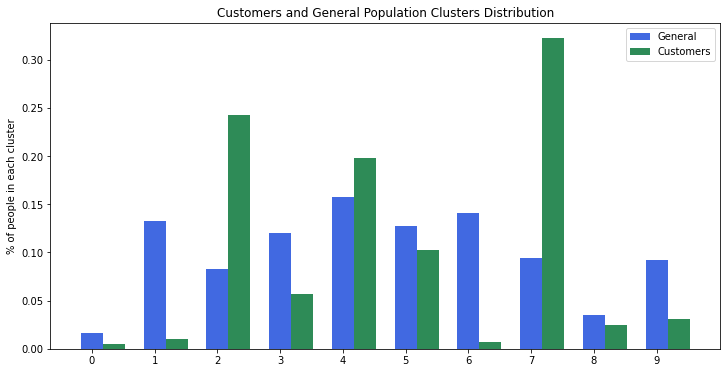

In [81]:
azdias_y = np.bincount(azdias_filtered_labels)
azdias_ii = np.nonzero(azdias_y)[0]
customers_y = np.bincount(customers_labels)
customers_ii = np.nonzero(customers_y)[0]
azdias_count = np.vstack((azdias_ii,azdias_y[azdias_ii])).T
customers_count = np.vstack((customers_ii,customers_y[customers_ii])).T
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_xticks(range(10))
rects1 = ax.bar(azdias_count[:, 0], azdias_count[:, 1]/len(azdias_filtered_labels), 0.35, color='royalblue')
rects2 = ax.bar(customers_count[:, 0]+0.35, customers_count[:, 1]/len(customers_labels), 0.35, color='seagreen')

ax.set_ylabel("% of people in each cluster")
ax.set_title("Customers and General Population Clusters Distribution")

ax.legend( (rects1[0], rects2[0]), ("General", 'Customers') )

plt.show()

The clusters that the general population are closer to the customer are 4 and 5 and the ones that the proportion is more different are 7 and 2

In [82]:
azdias_filtered['cluster'] = azdias_filtered_labels
customers_without_cols['cluster'] = customers_labels

In [89]:
azdias_clus_4 = azdias_filtered[azdias_filtered['cluster'] == 4]
cust_clus_4 = customers_without_cols[customers_without_cols['cluster']==4]

Seeing if there is some difference between the income, group age and gender of cluster 4

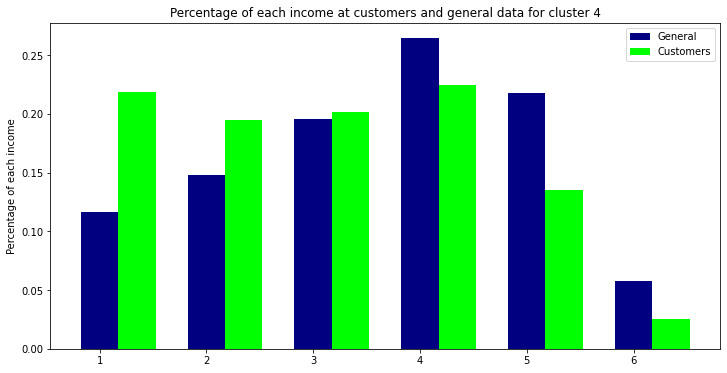

In [91]:
plot_comparative_bar_plot('HH_EINKOMMEN_SCORE', azdias_clus_4, cust_clus_4, 'Percentage of each income', 'Percentage of each income at customers and general data for cluster 4', color1='navy', color2='lime')

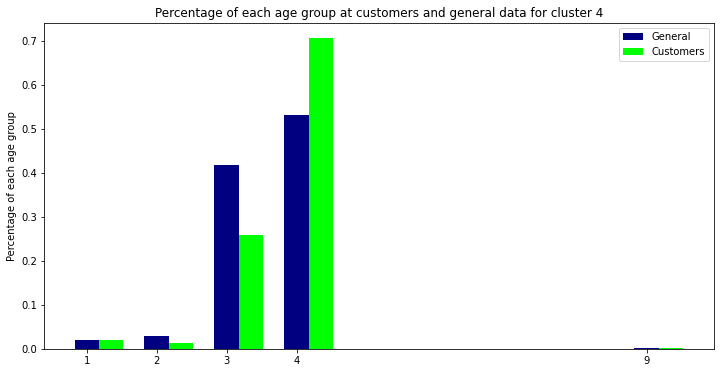

In [93]:
plot_comparative_bar_plot('ALTERSKATEGORIE_GROB', azdias_clus_4, cust_clus_4, 'Percentage of each age group', 'Percentage of each age group at customers and general data for cluster 4', color1='navy', color2='lime')

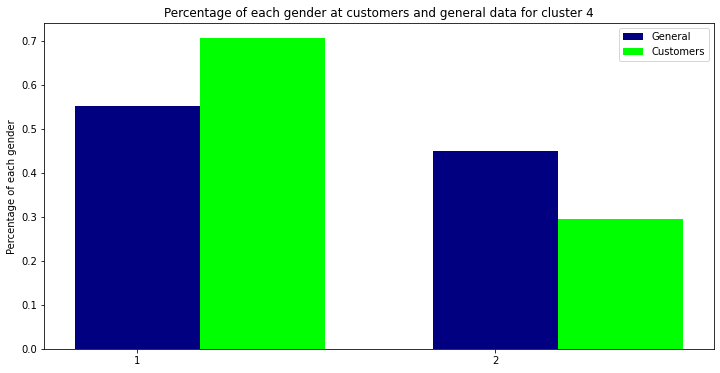

In [94]:
plot_comparative_bar_plot('ANREDE_KZ', azdias_clus_4, cust_clus_4, 'Percentage of each gender', 'Percentage of each gender at customers and general data for cluster 4', color1='navy', color2='lime')